# Visual Odometry

#### Steps of Feature-Based VO 

1. Feature Detection: Keypoints are detected in consecutive frames using algorithms like SIFT (Scale-Invariant Feature Transform), ORB (Oriented FAST and Rotated BRIEF), or SURF (Speeded-Up Robust Features).

2. Feature Matching: Keypoints in the current frame are matched with keypoints from the previous frame.

3. Motion Estimation: Once features are matched, the essential matrix or homography is computed, which allows for the calculation of the relative rotation (pitch, yaw, roll) between the frames.

----

# Data Loading

In [2]:
import os
import cv2
import joblib
import numpy as np
import pandas as pd
from cv2 import ORB_create
from skimage.feature import canny
from sklearn.decomposition import PCA
from skimage.transform import probabilistic_hough_line

from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from skimage.transform import probabilistic_hough_line
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2024-10-12 22:31:02.498336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Response Data Loading 

'''
Aim: store pitch and yaw angles with video and frame index
Method: iterates through the labeled txt files 
'''

directory = 'labeled'
data = []

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        video_title = filename.split('.')[0]
        filepath = os.path.join(directory, filename)
        
        with open(filepath, 'r') as file:
            content = file.read().strip()
        
            values = list(map(float, content.split()))
            
            for i in range(0, len(values), 2):
                frame_number = i // 2
                pitch = values[i]
                yaw = values[i + 1]
                
                data.append([video_title, frame_number, pitch, yaw])

# Creating a dataframe 
response_df = pd.DataFrame(data, columns=['video', 'frame', 'pitch', 'yaw'])
response_df = response_df.sort_values(by=['video', 'frame'])

# Saving the dataframe
response_df.to_csv("data/response_df.csv")

----

## Featured-based VO 

Feature-based VO is concerned with keypoint detection over time.
It involved several key steps including: 

1. Feature Detection 
2. Feature Matching 
3. Motion Estimation 

The following code is concerned with feature detection
using the ORB algorithm. 

In [78]:
# Imports
import cv2
import numpy as np
import os
import glob
import pandas as pd
from tqdm import tqdm 

### Calibration Settings

In [74]:

# Path to the directory containing extracted frames
FRAMES_DIR = 'extracted_frames'

# Output directory for storing pitch and yaw results
OUTPUT_DIR = 'vo_predict'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Approximate Camera Intrinsic Parameters
focal_length = 910  
principal_point = (582, 437) 
K = np.array([[focal_length, 0, principal_point[0]],
              [0, focal_length, principal_point[1]],
              [0, 0, 1]])

# Initialize ORB detector
ORB_FEATURES = 2000
orb = cv2.ORB_create(ORB_FEATURES)

# Initialize Brute-Force Matcher with Hamming distance
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Define the number of good matches to retain (e.g., top 50%)
GOOD_MATCH_PERCENT = 0.5


### Helper Functions

In [88]:
def extract_features(frame):
    """
    Extract ORB keypoints and descriptors from a frame.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    return keypoints, descriptors

def match_features(des1, des2):
    """
    Match ORB descriptors between two frames using BFMatcher.
    Returns sorted good matches.
    """
    if des1 is None or des2 is None:
        return []

    matches = bf.match(des1, des2)
    # Sort matches by distance (best matches first)
    matches = sorted(matches, key=lambda x: x.distance)
    # Retain top GOOD_MATCH_PERCENT matches
    num_good_matches = int(len(matches) * GOOD_MATCH_PERCENT)
    good_matches = matches[:num_good_matches]
    return good_matches

def compute_rotation_euler(R):
    """
    Compute Euler angles (pitch, yaw, roll) from a rotation matrix.
    Returns angles in degrees.
    """
    sy = np.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])

    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2,1] , R[2,2])  # Roll
        y = np.arctan2(-R[2,0], sy)      # Pitch
        z = np.arctan2(R[1,0], R[0,0])   # Yaw
    else:
        x = np.arctan2(-R[1,2], R[1,1])
        y = np.arctan2(-R[2,0], sy)
        z = 0

    # Convert from radians to degrees
    roll = x #np.radians(x)
    pitch = y #np.radians(y)
    yaw = z #np.radians(z)
    
    return pitch, yaw, roll

def process_video(video_path, video_name):
    """
    Process all frames in a single video directory to estimate pitch and yaw angles.
    Stores the results in a CSV file.
    """
    # Get list of frame file paths sorted numerically
    frame_files = sorted(glob.glob(os.path.join(video_path, '*.jpg')),
                         key=lambda x: int(os.path.splitext(os.path.basename(x))[0].replace('frame_', '')))
    
    if len(frame_files) < 2:
        print(f"Not enough frames in {video_name} to perform visual odometry.")
        return
    
    # Initialize lists to store pitch and yaw
    pitches = []
    yaws = []
    frame_indices = []
    
    # Read the first frame
    prev_frame = cv2.imread(frame_files[0])
    prev_kp, prev_des = extract_features(prev_frame)
    
    for idx in tqdm(range(1, len(frame_files)), desc=f"Processing {video_name}"):
        frame_file = frame_files[idx]
        frame = cv2.imread(frame_file)
        if frame is None:
            print(f"Failed to read {frame_file}. Skipping.")
            continue
        
        kp, des = extract_features(frame)
        
        # Match features between previous and current frame
        good_matches = match_features(prev_des, des)
        
        if len(good_matches) < 8:
            # Essential matrix requires at least 8 points
            print(f"Not enough good matches in frame {idx+1} of {video_name}. Skipping.")
            pitches.append(None)
            yaws.append(None)
            frame_indices.append(idx+1)
            continue
        
        # Extract matched keypoints
        pts1 = np.float32([prev_kp[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        pts2 = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
        
        # Compute Essential matrix using RANSAC
        E, mask = cv2.findEssentialMat(pts2, pts1, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        
        if E is None:
            print(f"Essential matrix not found in frame {idx+1} of {video_name}. Skipping.")
            pitches.append(None)
            yaws.append(None)
            frame_indices.append(idx+1)
            continue
        
        # Recover pose from Essential matrix
        _, R, t, mask_pose = cv2.recoverPose(E, pts2, pts1, K)
        
        # Extract Euler angles
        pitch, yaw, roll = compute_rotation_euler(R)
        pitches.append(pitch)
        yaws.append(yaw)
        frame_indices.append(idx+1)
        
        # Update previous frame and keypoints
        prev_frame = frame
        prev_kp, prev_des = kp, des
    

    # Create a DataFrame to store the results
    df = pd.DataFrame({
        'Frame': frame_indices,
        'Pitch (degrees)': pitches,
        'Yaw (degrees)': yaws
    })
    
    # Save to CSV
    output_csv = os.path.join(OUTPUT_DIR, f"{video_name}_pitch_yaw.csv")
    df.to_csv(output_csv, index=False)
    print(f"Saved pitch and yaw estimates for {video_name} to {output_csv}")


### Main Process Function 

In [89]:

def main():
    """
    Main function to process all videos in the 'extracted_frames' directory.
    """
    # Get list of all video directories
    video_dirs = [d for d in os.listdir(FRAMES_DIR) if os.path.isdir(os.path.join(FRAMES_DIR, d))]
    
    if not video_dirs:
        print("No video directories found in 'extracted_frames'.")
        return
    
    for video_name in video_dirs:
        video_path = os.path.join(FRAMES_DIR, video_name)
        print(f"\nStarting visual odometry for {video_name}...")
        process_video(video_path, video_name)

if __name__ == "__main__":
    main()


Starting visual odometry for video_2...


Processing video_2: 100%|██████████| 1199/1199 [01:22<00:00, 14.56it/s]


Saved pitch and yaw estimates for video_2 to vo_predict/video_2_pitch_yaw.csv

Starting visual odometry for video_5...


Processing video_5: 100%|██████████| 1199/1199 [00:57<00:00, 20.71it/s]


Saved pitch and yaw estimates for video_5 to vo_predict/video_5_pitch_yaw.csv

Starting visual odometry for video_4...


Processing video_4: 100%|██████████| 1199/1199 [01:19<00:00, 15.06it/s]


Saved pitch and yaw estimates for video_4 to vo_predict/video_4_pitch_yaw.csv

Starting visual odometry for video_3...


Processing video_3: 100%|██████████| 1199/1199 [01:15<00:00, 15.96it/s]


Saved pitch and yaw estimates for video_3 to vo_predict/video_3_pitch_yaw.csv

Starting visual odometry for video_6...


Processing video_6: 100%|██████████| 1199/1199 [00:44<00:00, 27.24it/s]


Saved pitch and yaw estimates for video_6 to vo_predict/video_6_pitch_yaw.csv

Starting visual odometry for video_1...


Processing video_1: 100%|██████████| 1199/1199 [00:50<00:00, 23.78it/s]


Saved pitch and yaw estimates for video_1 to vo_predict/video_1_pitch_yaw.csv

Starting visual odometry for video_8...


Processing video_8: 100%|██████████| 1199/1199 [01:01<00:00, 19.49it/s]


Saved pitch and yaw estimates for video_8 to vo_predict/video_8_pitch_yaw.csv

Starting visual odometry for video_9...


Processing video_9: 100%|██████████| 1199/1199 [01:18<00:00, 15.26it/s]


Saved pitch and yaw estimates for video_9 to vo_predict/video_9_pitch_yaw.csv

Starting visual odometry for video_0...


Processing video_0: 100%|██████████| 1199/1199 [00:49<00:00, 24.05it/s]


Saved pitch and yaw estimates for video_0 to vo_predict/video_0_pitch_yaw.csv

Starting visual odometry for video_7...


Processing video_7: 100%|██████████| 1199/1199 [00:51<00:00, 23.51it/s]

Saved pitch and yaw estimates for video_7 to vo_predict/video_7_pitch_yaw.csv


---

## Evaluation 



In [90]:

# Directories
input_dir = 'vo_predict'  # Directory where your CSV files are stored
output_dir = 'predict'    # Directory where the .txt files will be saved

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop over each CSV file in the 'vo_predict' directory
for filename in os.listdir(input_dir):
    if filename.endswith('.csv'):
        # Construct full file path
        csv_path = os.path.join(input_dir, filename)
        
        # Read the CSV file
        data = pd.read_csv(csv_path)
        
        # Assuming pitch and yaw are stored in specific columns, replace 'pitch_column' and 'yaw_column' with actual names
        pitch_column = 'Pitch (degrees)'  # Change this to your actual column name for pitch
        yaw_column = 'Yaw (degrees)'      # Change this to your actual column name for yaw
        
        # Extract the pitch and yaw angles
        if pitch_column in data.columns and yaw_column in data.columns:
            pitch_yaw = data[[pitch_column, yaw_column]].values
        else:
            raise ValueError(f'Pitch and/or yaw columns not found in {filename}')
        
        # Convert the CSV filename to a .txt filename
        txt_filename = filename.replace('.csv', '.txt')
        txt_path = os.path.join(output_dir, txt_filename)
        
        # Save the pitch and yaw angles as a .txt file
        np.savetxt(txt_path, pitch_yaw, delimiter=' ')
        
        print(f'Saved pitch and yaw angles to {txt_path}')


Saved pitch and yaw angles to predict/video_7_pitch_yaw.txt
Saved pitch and yaw angles to predict/video_3_pitch_yaw.txt
Saved pitch and yaw angles to predict/video_4_pitch_yaw.txt
Saved pitch and yaw angles to predict/video_0_pitch_yaw.txt
Saved pitch and yaw angles to predict/video_9_pitch_yaw.txt
Saved pitch and yaw angles to predict/video_8_pitch_yaw.txt
Saved pitch and yaw angles to predict/video_1_pitch_yaw.txt
Saved pitch and yaw angles to predict/video_5_pitch_yaw.txt
Saved pitch and yaw angles to predict/video_2_pitch_yaw.txt
Saved pitch and yaw angles to predict/video_6_pitch_yaw.txt


## Visualization 1

Mean Squared Error for Yaw (Linear Regression): 0.02550029516604147


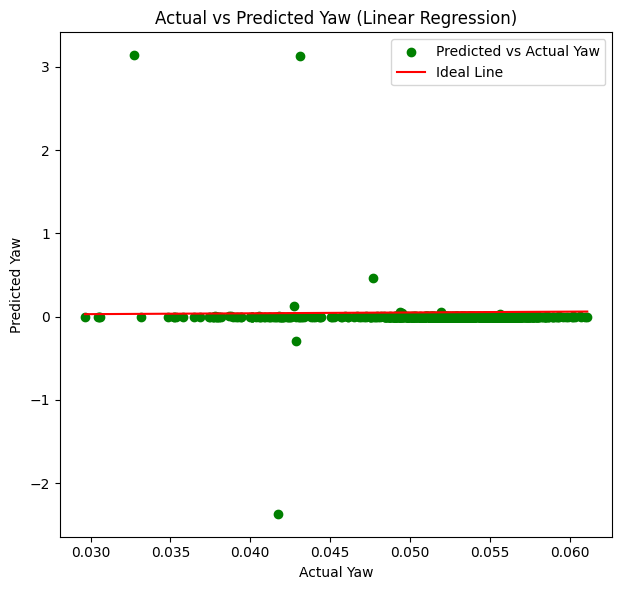

In [91]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#pred_df = pd.read_csv('vo_predict/video_0_pitch_yaw.csv')['Pitch (degrees)']
pred_df = np.loadtxt('predict/video_4_pitch_yaw.txt')[:,1]
real_df = np.loadtxt('labeled/4.txt')[:,1]

# Conforming to pandas df
pred_df = pd.DataFrame(pred_df)
real_df = pd.DataFrame(real_df)

# Removing NAs
def remove_na(pred_df, real_df): 
    merged_df = pd.concat([pred_df,real_df], axis=1) # Merge together
    merged_df = merged_df.dropna() # Remove any row (prediction or real) with NA

    return merged_df.iloc[:,0], merged_df.iloc[:,1] # Return pred, real separately
 
pred_df, real_df = remove_na(pred_df, real_df)

# Step 3: Evaluate the model using mean squared error (MSE) for yaw
mse_yaw = mean_squared_error(real_df, pred_df)

print(f"Mean Squared Error for Yaw (Linear Regression): {mse_yaw}")

# Step 4: Visualize the predictions vs actual for yaw
plt.figure(figsize=(12, 6))

# Plot for Yaw
plt.subplot(1, 2, 2)
plt.scatter(real_df, pred_df, color='green', label='Predicted vs Actual Yaw')
plt.plot([min(real_df), max(real_df)], [min(real_df), max(real_df)], color='red', label='Ideal Line')
plt.xlabel('Actual Yaw')
plt.ylabel('Predicted Yaw')
plt.title('Actual vs Predicted Yaw (Linear Regression)')
plt.legend()

plt.tight_layout()
plt.show()


## Visualization 2

Mean Squared Error for Pitch: 0.0025
Mean Squared Error for Yaw: 0.0010


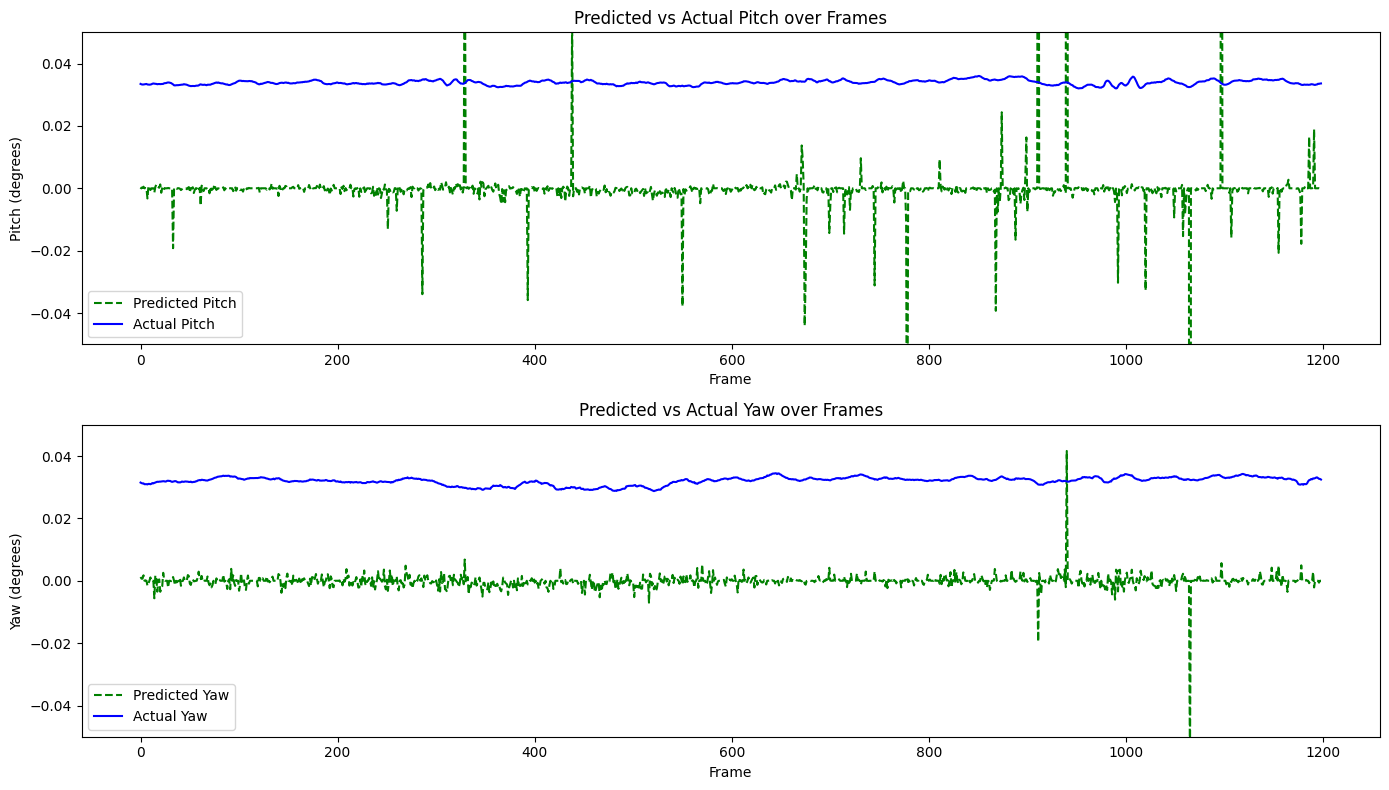

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load prediction and real data for both pitch and yaw
pred_pitch_yaw = np.loadtxt('predict/video_0_pitch_yaw.txt')
real_pitch_yaw = np.loadtxt('labeled/0.txt')

# Extract pitch and yaw from both the predictions and the real data
pred_pitch = pred_pitch_yaw[:, 0]  # First column is pitch
pred_yaw = pred_pitch_yaw[:, 1]    # Second column is yaw
real_pitch = real_pitch_yaw[:, 0]  # First column is pitch
real_yaw = real_pitch_yaw[:, 1]    # Second column is yaw

# Convert to DataFrame for easier handling and removing NaN values
pred_df = pd.DataFrame({'Pitch': pred_pitch, 'Yaw': pred_yaw})
real_df = pd.DataFrame({'Pitch': real_pitch, 'Yaw': real_yaw})

# Removing NAs
def remove_na(pred_df, real_df): 
    merged_df = pd.concat([pred_df, real_df], axis=1, keys=['Pred', 'Real'])  # Merge together with keys for clarity
    merged_df = merged_df.dropna()  # Remove rows with NA values

    return merged_df['Pred'], merged_df['Real']  # Return prediction and real values separately

# Clean data to remove NaN values
pred_df, real_df = remove_na(pred_df, real_df)

# Step 1: Calculate Mean Squared Error for both Pitch and Yaw
mse_pitch = mean_squared_error(real_df['Pitch'], pred_df['Pitch'])
mse_yaw = mean_squared_error(real_df['Yaw'], pred_df['Yaw'])

print(f"Mean Squared Error for Pitch: {mse_pitch:.4f}")
print(f"Mean Squared Error for Yaw: {mse_yaw:.4f}")

# Step 2: Define a function to set axis limits to focus on the majority of values
def set_focus_lims(data, margin=1.5):
    """
    Set the y-axis limits based on the interquartile range (IQR) to ignore outliers.
    margin: How much to extend the limits based on the IQR range.
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - margin * iqr
    upper_bound = q3 + margin * iqr
    return lower_bound, upper_bound

# Step 3: Plot Pitch and Yaw over frames
plt.figure(figsize=(14, 8))

# Plot Pitch
plt.subplot(2, 1, 1)
plt.plot(pred_df.index, pred_df['Pitch'], label='Predicted Pitch', color='green', linestyle='--')
plt.plot(real_df.index, real_df['Pitch'], label='Actual Pitch', color='blue', linestyle='-')
plt.title('Predicted vs Actual Pitch over Frames')
plt.xlabel('Frame')
plt.ylabel('Pitch (degrees)')
plt.legend()

# Set y-axis limits to focus on the majority of values (ignore outliers)
#pitch_lims = set_focus_lims(real_df['Pitch'])
plt.ylim(-0.05, 0.05)

# Plot Yaw
plt.subplot(2, 1, 2)
plt.plot(pred_df.index, pred_df['Yaw'], label='Predicted Yaw', color='green', linestyle='--')
plt.plot(real_df.index, real_df['Yaw'], label='Actual Yaw', color='blue', linestyle='-')
plt.title('Predicted vs Actual Yaw over Frames')
plt.xlabel('Frame')
plt.ylabel('Yaw (degrees)')
plt.legend()

# Set y-axis limits to focus on the majority of values (ignore outliers)
#yaw_lims = set_focus_lims(real_df['Yaw'])
plt.ylim(-0.05, 0.05)

plt.tight_layout()
plt.show()
